In [1]:
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from lightgbm import *
import math

from cpcv_util import *

In [2]:
# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(17):
        _df = df[(df['pred'] >= pred_min + 0.5 * pred_std * i) & (df['pred'] < pred_min + 0.5 * pred_std * (i + 1))]
        pred_sections.append(pred_min + 0.5 * pred_std * i)
        true_means.append(_df['true'].mean())
    
    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    #ax[0, 0].scatter(df.loc[df['true'] != 0,'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].scatter(df['pred'], df['true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='post')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    ax[0, 0].set_xticks([pred_mean, pred_mean - 2*pred_std, pred_mean - 4*pred_std, pred_mean + 2*pred_std, pred_mean + 4*pred_std])
    ax[0, 0].set_yticks([true_mean, true_mean - 2*true_std, true_mean - 4*true_std, true_mean + 2*true_std, true_mean + 4*true_std])
    ax[0, 0].grid(axis = 'both')
    ax[0, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    ax[0, 0].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    # 0と予測した値を表示するとヒストグラムがまともに見えないので除外している
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].grid(axis = 'both')
    ax[1, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    ax[0, 1].grid(axis = 'both')
    ax[0, 1].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[1, 1].remove()
    
    fig.show()

,x,y,y_noise
0,-1.329366,-0.970997,-1.244121
1,-2.448020,-0.639289,-0.821962
2,-6.139323,0.143366,0.116180
3,1.620913,0.998744,1.054881
4,-3.604391,0.446454,0.560643
...,...,...,...
9995,-3.342926,0.199976,0.481888
9996,5.281194,-0.842545,-0.678216
9997,-1.877715,-0.953269,-1.266207
9998,-0.369074,-0.360752,-0.059508


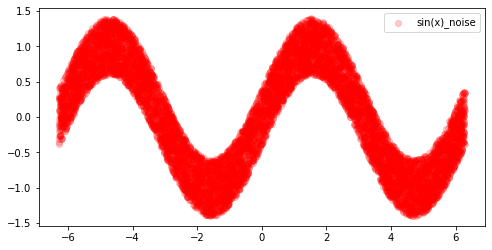

In [3]:
sample_size = 10000
#x = np.linspace(-10, 10, sample_size)
x = [random.uniform(-2 * math.pi, 2 * math.pi) for x in range(sample_size)]
y = np.sin(x)
y_noise = y + np.random.uniform(-0.4, 0.4, sample_size)

df = pd.DataFrame({'x': x, 'y': y, 'y_noise': y_noise})

plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='sin(x)_noise', color='red', alpha=0.2)
plt.legend()

display(df)

In [4]:
# Optunaを使わずに、LightGBMのみを使ったシンプルな学習を行う
params = {
    'objective':'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'extra_trees': True,
    'deterministic': True,
    'force_row_wise': True,
    'num_threads': 8
}

lgbr = LGBMRegressor(**params)
model = lgbr.fit(df[['x']], df['y_noise'])
df['y_pred'] = model.predict(df[['x']])

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8


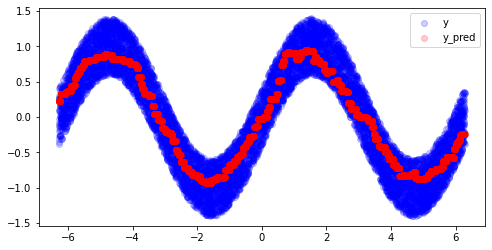

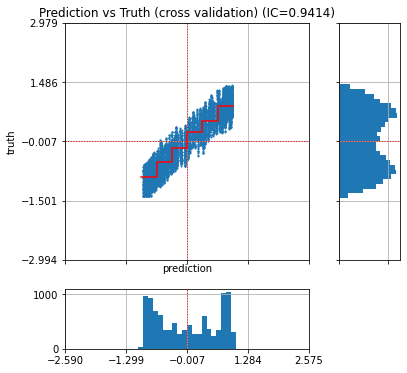

In [5]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [6]:
# Optunaを使い、ハイパーパラメータチューニングを伴ったLightGBMの学習を行う
import optuna
import optuna.integration.lightgbm as lgb_optuna

# 固定するLightGBMのパラメータ
train_fixed_params = {
    'objective':'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'extra_trees': True,
    'deterministic': True,
    'force_row_wise': True,
    'num_threads': 8
}

# Optunaを使って最適パラメータを探しながらモデルをトレーニングする関数
def optuna_optimize_cv(df_train=None, df_target=None, folds=None, params=None):
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    
    # トレーニングデータをLightGBMで使う形式に変換
    lgb_train_data = lgb_optuna.Dataset(df_train, df_target, free_raw_data=False)
    
    # 与えられたfoldを利用して、CVを使った学習を行う
    optuna_search = optuna.integration.LightGBMTunerCV(params,
                                                       train_set = lgb_train_data,
                                                       folds = folds,
                                                       early_stopping_rounds = 100,
                                                       verbose_eval = 0,
                                                       show_progress_bar = False,
                                                       optuna_seed = 47,
                                                       return_cvbooster = True)
    optuna_search.run()        
    return optuna_search.get_best_booster(), optuna_search.best_params

# 特徴量はxのみ
features = ['x']

# CPCVによるトレーニングとバリデーション区間の決定
folds = cpcv_split(df)
display(folds)

# Optunaを利用した学習を開始
model_cv, model_param_cv = optuna_optimize_cv(df[features], df['y_noise'], folds, train_fixed_params)

[(array([   0,    1,    2, ..., 6465, 6466, 6467]),
  array([6668, 6669, 6670, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 8131, 8132, 8133]),
  array([5001, 5002, 5003, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([5001, 5002, 5003, ..., 8331, 8332, 8333])),
 (array([   0,    1,    2, ..., 8131, 8132, 8133]),
  array([3334, 3335, 3336, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([3334, 3335, 3336, ..., 8331, 8332, 8333])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([3334, 3335, 3336, ..., 6665, 6666, 6667])),
 (array([   0,    1,    2, ..., 8131, 8132, 8133]),
  array([1667, 1668, 1669, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([1667, 1668, 1669, ..., 8331, 8332, 8333])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([1667, 1668, 1669, ..., 6665, 6666, 6667])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  a

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

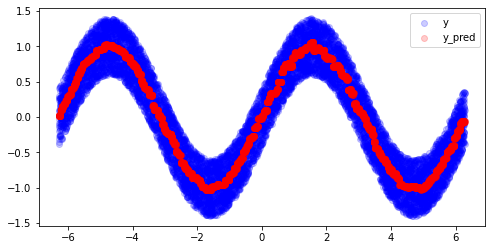

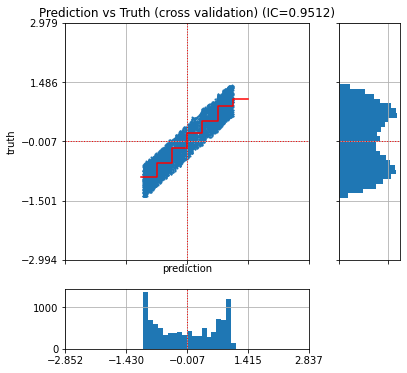

In [7]:
# 学習区間について予測を行い、Optunaを使って学習したモデルの性能を確認する
df_predict = pd.DataFrame(model_cv.predict(df[features], num_iteration=model_cv.best_iteration))

# df_predictにはCPCVの結果作られた15個の予測器からの出力が入っているので、これらを平均して最終の予測とする
df_predict = df_predict.transpose()
df_predict.index = df.index # これをやらないとdfのindexが0から始まる連番でない場合にバグる
for index, fold in enumerate(folds):
    df_predict.iloc[fold[1], index] = np.nan # バリデーション区間の予測値をnanで上書きする
df['y_pred'] = df_predict.mean(axis=1) # 残った予測値を使って平均値を計算する

plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

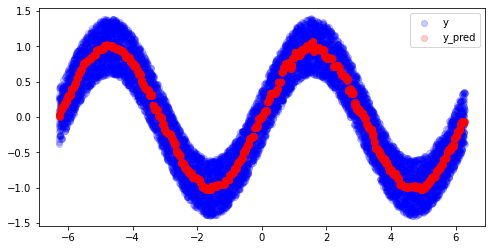

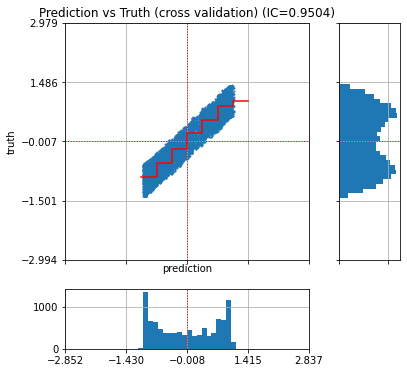

In [8]:
# バリデーション区間について予測を行い、Optunaを使って学習したモデルの性能を確認する
df_predict = pd.DataFrame(model_cv.predict(df[features], num_iteration=model_cv.best_iteration))

# df_predictにはCPCVの結果作られた15個の予測器からの出力が入っているので、これらを平均して最終の予測とする
df_predict = df_predict.transpose()
df_predict.index = df.index # これをやらないとdfのindexが0から始まる連番でない場合にバグる
for index, fold in enumerate(folds):
    df_predict.iloc[fold[0], index] = np.nan # バリデーション区間の予測値をnanで上書きする
df['y_pred'] = df_predict.mean(axis=1) # 残った予測値を使って平均値を計算する

plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [ ]:
# このテストコードにテスト区間はない